### Summary 
#### Introduction
#### I) Database
#### II) Features extraction and selection
#### III) Classification
#### IV) Evaluation 
#### Conclusion 
#### References

#### Introduction:
In this project we will try to propose a methodology for automatic classificaton of skin lesions based on image processing and classification algorithms of machine learning.
We have a database of images which we will describe using geometrical/ morphological descriptors using the binary segmented images and intensity/ texture descriptors using both the original and superpixel images. Using these features will try to use machine learning tools to classify the images in two classes: benign lesions or melanomas.

In [7]:
# Necessary importations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern

from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif , chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import torch



In [2]:
import cv2

#### I) Database :
we load  the different images from the database with suitable names( original for the original images , segmented for segmented images an superpixeled for superpixeled images)

In [3]:
# loadig the data with suitable names 
dir = "./PROJECT_Data"
elements = sorted(os.listdir(dir))[0:]

original = []
segmentated = []
superpixeled = [] 
L=[]
for element in elements:
    id = element[:12]
    L.append(id) # stores image ids to find their labels 
    if element == (id + ".jpg"):
        original.append(cv2.imread(dir + "/" + element))


We load the labels of our data and store them in Y

In [4]:
# information about the images from the csv database

infos = pd.read_csv("ISIC-2017_Data_GroundTruth_Classification.csv", delimiter = ",")
infos.head()

Y=[]
for j in range(2000):
    if (infos['image_id'][j]in L):
        Y.append(int(infos['melanoma'][j]))

In [5]:
import numpy as np
from skimage.transform import resize

# Find the smallest dimensions in the dataset
min_height = min(img.shape[0] for img in original)
min_width = min(img.shape[1] for img in original)

# Resize all images to the smallest dimensions
resized_images = [resize(img, (224, 224)) for img in original]

In [8]:
# lets trt classification with CNN with pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision import transforms
from PIL import Image

import numpy as np
from skimage.transform import resize

# Find the smallest dimensions in the dataset
min_height = min(img.shape[0] for img in original)
min_width = min(img.shape[1] for img in original)

# Resize all images to the smallest dimensions
resized_images = [resize(img, (224, 224)) for img in original]
# Convert the images and change dimensions
original_tensors = [torch.from_numpy(img).permute(2, 0, 1).float() for img in resized_images]
Y_tensor = torch.Tensor(Y).long()  # labels should be long type



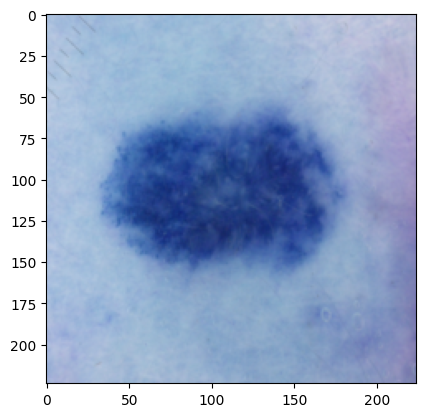

In [11]:
#plot random images 
plt.imshow(resized_images[78])

In [34]:



# Define the CNN model
class SkinLesionCNN(nn.Module):
    def __init__(self):
        super(SkinLesionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 56*56, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes (lesion or not)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = SkinLesionCNN()

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




# Update the dataset with the new transformations
dataset = TensorDataset(torch.stack(original_tensors), Y_tensor)
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])



# Update data loaders
batch_size =64


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [35]:
# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

# Evaluation loop (after training)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

print("Finished Training and Evaluation")



Epoch 1/15, Loss: 3.6437917351722717
Epoch 2/15, Loss: 0.9082793196042379
Epoch 3/15, Loss: 0.8392231663068136
Epoch 4/15, Loss: 0.6162419617176056
Epoch 5/15, Loss: 0.6613810261090597
Epoch 6/15, Loss: 0.6341484586397806
Epoch 7/15, Loss: 0.5581711332003275
Epoch 8/15, Loss: 0.5050771633783976
Epoch 9/15, Loss: 0.5378163754940033
Epoch 10/15, Loss: 0.4962531824906667
Epoch 11/15, Loss: 0.4953211148579915
Epoch 12/15, Loss: 0.471594899892807
Epoch 13/15, Loss: 0.4327305754025777
Epoch 14/15, Loss: 0.4533909261226654
Epoch 15/15, Loss: 0.4093218346436818
Finished Training
Accuracy on the test set: 72.00%
Finished Training and Evaluation


In [36]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained model
model = models.resnet50(pretrained=True)

In [40]:

batch_size = 32


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Move the model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Finished Training")

# Evaluation loop (after training)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

print("Finished Training and Evaluation")


Epoch 1/15, Loss: 0.6937388777732849
Epoch 2/15, Loss: 0.5802277088165283
Epoch 3/15, Loss: 0.49367128014564515
Epoch 4/15, Loss: 0.45926937460899353
Epoch 5/15, Loss: 0.4147589087486267
Epoch 6/15, Loss: 0.39567304849624635
Epoch 7/15, Loss: 0.3522242844104767
Epoch 8/15, Loss: 0.3460115432739258
Epoch 9/15, Loss: 0.3287147879600525
Epoch 10/15, Loss: 0.3051195561885834
Epoch 11/15, Loss: 0.28805599808692933
Epoch 12/15, Loss: 0.286308354139328
Epoch 13/15, Loss: 0.2745089948177338
Epoch 14/15, Loss: 0.258568087220192
Epoch 15/15, Loss: 0.24436044991016387
Finished Training
Accuracy on the test set: 64.00%
Finished Training and Evaluation


## II) Feature Extraction 
#### 1) Extracting geometrical/morphological descriptors using the binary segmented image
We use the same shape descriptors we used in the first project, using the binary segmented images we extract 11 features using regionprops function from the skimage library. The features are: Area - Eccentricity - Perimeter -Solidity - Minor Axis Length – Major Axis Length - Extent – Equivalent diameter – Convex area- Bbox area. We extract these features using the function get_shape_features as follows:


In [5]:
# feature extraction using LBP and region properties

# Extracting geometrical/morphological descriptors using the binary segmented image

def get_shape_features(image_region):
   
    shape_features = []

    region=label(image_region)
    rgprops = regionprops(region)

    shape_features.append(rgprops[0].area)
    shape_features.append(rgprops[0].eccentricity)
    shape_features.append(rgprops[0].perimeter)
    shape_features.append(rgprops[0].equivalent_diameter)
    shape_features.append(rgprops[0].extent)
    shape_features.append(rgprops[0].bbox_area)
    shape_features.append(rgprops[0].convex_area)
    shape_features.append(rgprops[0].minor_axis_length)
    shape_features.append(rgprops[0].major_axis_length)
    shape_features.append(rgprops[0].major_axis_length/rgprops[0].minor_axis_length)
    shape_features.append(rgprops[0].solidity)

    return np.array(shape_features)


We store these features in a dataframe called features_data_segmentated.

In [6]:

features_data_segmentated = np.zeros((len(segmentated), 11))
for i in range(0, len(segmentated)):
    image_seg = segmentated[i].astype("bool")
    shape_features = get_shape_features(image_seg)
    features_data_segmentated[i,:] = shape_features
    
features_data_segmentated = pd.DataFrame(features_data_segmentated, columns = ["Area", "Eccentricity", "Perimeter", "Equivalent Diameter",  "Extent", "Bbox Area", " Convex Area", "Minor Axis Length", "Major Axis Length", "Ratio", "Solidity"])
features_data_segmentated.head()

,Area,Eccentricity,Perimeter,Equivalent Diameter,Extent,Bbox Area,Convex Area,Minor Axis Length,Major Axis Length,Ratio,Solidity
0,364956.0,0.757181,2586.885569,681.671777,0.731926,498624.0,376696.0,556.405972,851.808557,1.530912,0.968834
1,53432.0,0.436456,1068.915872,260.828939,0.749923,71250.0,57639.0,249.034859,276.789839,1.111450,0.927011
2,237402.0,0.597147,2421.010460,549.790519,0.642384,369564.0,259261.0,496.327926,618.761026,1.246678,0.915687
3,260712.0,0.433660,2187.655121,576.150005,0.707612,368439.0,272733.0,551.560706,612.112946,1.109783,0.955924
4,269484.0,0.666933,2014.410388,585.762482,0.757791,355618.0,273211.0,508.604676,682.583151,1.342070,0.986359


### 2) Extracting texture descriptors using the original images
The Local Binary Patterns (LBP) descriptor is a simple yet very efficient texture operator which labels the pixels
of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. Due
to its discriminative power and computational simplicity, LBP texture operator has become a popular approach
in various applications. It can be seen as a unifying approach to the traditionally divergent statistical and
structural models of texture analysis. Perhaps the most important property of the LBP operator in real-world
applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations.
Another important property is its computational simplicity, which makes it possible to analyze images in
challenging real-time settings.
The LBP feature vector, in its simplest form, is created in the following manner:
- For each pixel, compare the pixel to each of its 8 neighbors (on its left-top, left-middle, left-bottom,
right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise.
- Where the center pixel’s value is greater than the neighbor’s value, write "1". Otherwise, write "0". This
gives an 8-digit binary number (which is usually converted to decimal for convenience).
- Compute the histogram of the frequency of each "number" occurring (i.e., each combination of which
pixels are smaller and which are greater than the center).
- Normalize the histogram

We extract the features using the function local_binary_patter from skimage library as follows 

In [7]:
# Extracting texture descriptors using the original images
feat_nbr = 30
LBP_feat = np.empty((len(original), feat_nbr))

#Extracting the Features
for i, img in enumerate(original):
    copie = np.copy(img)    
    #Extracting the 3 components (Red, green and blue)
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    V = []
    for j,img_colored in enumerate([R,G,B]):        
        LBP = local_binary_pattern(img_colored,8,1,'uniform')
        x = itemfreq(LBP.ravel())
        hist = x[:, 1]
        for h in hist:
            V.append(h)
            
    LBP_feat[i, :] = V

LBP_feat = pd.DataFrame(LBP_feat, columns= ["Feature " + str(i) for i in range(feat_nbr)])


In [8]:
LBP_feat.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
0,7719.0,24843.0,16719.0,87098.0,101096.0,183378.0,59418.0,46785.0,212233.0,44585.0,...,10150.0,32233.0,17239.0,87469.0,87455.0,182094.0,64677.0,51019.0,195949.0,55589.0
1,4355.0,21911.0,7706.0,82041.0,56648.0,202858.0,52933.0,56216.0,260861.0,38345.0,...,4446.0,22212.0,7438.0,80187.0,54675.0,199924.0,52047.0,57056.0,267123.0,38766.0
2,7909.0,28603.0,20071.0,111984.0,143501.0,195732.0,76313.0,51630.0,98639.0,49492.0,...,11188.0,38538.0,20781.0,103546.0,115385.0,180728.0,82175.0,57423.0,109680.0,64430.0
3,6738.0,22540.0,13677.0,78789.0,85540.0,181886.0,49872.0,42416.0,262095.0,40321.0,...,7284.0,23827.0,13521.0,74850.0,77806.0,175217.0,49807.0,44510.0,274161.0,42891.0
4,5522.0,15661.0,12577.0,61784.0,106169.0,118445.0,36548.0,23780.0,369199.0,34189.0,...,7026.0,18903.0,13409.0,58397.0,94800.0,112427.0,38427.0,26917.0,373834.0,39734.0


### 3) Extracting intensity descriptors using the superpixel images
We Compute the number of superpixels in every image by extracting the green and red components then we select the significant indexes of the red component to finally extract the superpixels and remove the duplicated values.


In [9]:
superpixels_nbr = []
for i in range(200):
    spr = superpixeled[i]
    # Green component of the superpixeled imahe
    G = np.reshape(np.array(spr[:,:,1]), (1,-1))
    G = G[0]
    #The Red component of the superpixeled image
    R = np.reshape(np.array(spr[:,:,0]), (1,-1))
    R = R[0]
    #indexes of the last layer which are significative of the red component
    idxs = [i for i in range(len(G)) if G[i] == 3]
    #extraction of the superpixels in the layer
    sp_layer = R[idxs]
    #keeping only unique values
    r_sub = list(dict.fromkeys(sp_layer))
    superpixels_nbr = superpixels_nbr + [max(r_sub)]





## III) Classification
We combine all the features in one dataFrame , then we proceed to feature selection , because having too many features may lead to overfitting


In [15]:
Data = pd.concat([features_data_segmentated,LBP_feat, pd.DataFrame(superpixels_nbr, columns = ["Superpixels"])], axis = 1)

We normalize the data using min_max_scaller then we split it into train and test to proceed and test some machine learning classification algorithms

In [16]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(Data)
X = pd.DataFrame(X, columns = Data.columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1234)


we perform classification using 6 machine learing classifiers which are : Logistic Regression, Decision Trees, Random forests, SVM, Stochastic gradient, Gradient boosting. we perfom a cross validation to see the average perfomance of our classifiers to avoid being affected by the initial split into train, test

In [17]:
# Defining the machine learning models
import random
import statistics as st


# Defining the machine learning models
logR= LogisticRegression() 
RdForest=RandomForestClassifier()
SVM=svm.SVC(kernel='rbf',probability=True)
Tree = DecisionTreeClassifier(max_depth=3) 
Sgd=SGDClassifier()
Gradient_boost=GradientBoostingClassifier()
Knn= KNeighborsClassifier(n_neighbors=5) 


#Cross validation
n_samples = 100
accuracies1 = np.zeros(n_samples)
accuracies2 = np.zeros(n_samples)
accuracies3 = np.zeros(n_samples)
accuracies4 = np.zeros(n_samples)
accuracies5 = np.zeros(n_samples)
accuracies6 = np.zeros(n_samples)
accuracies7 = np.zeros(n_samples)

f1_scores1 = np.zeros(n_samples)
f1_scores2 = np.zeros(n_samples)
f1_scores3 = np.zeros(n_samples)
f1_scores4 = np.zeros(n_samples)
f1_scores5 = np.zeros(n_samples)
f1_scores6 = np.zeros(n_samples)
f1_scores7 = np.zeros(n_samples)
for k in range(n_samples):
    #splitting data into train/test
    random.seed(k)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)
    #Training the models
    logR.fit(X_train, Y_train)
    RdForest.fit(X_train, Y_train)
    SVM.fit(X_train, Y_train)
    Tree.fit(X_train, Y_train)
    Sgd.fit(X_train, Y_train)
    Gradient_boost.fit(X_train,Y_train)
    Knn.fit(X_train, Y_train)
        
    # predicitions
    pred1 = logR.predict(X_test)
    pred2 = RdForest.predict(X_test)
    pred3 = SVM.predict(X_test)
    pred4 = Tree.predict(X_test)
    pred5 = Sgd.predict(X_test)
    pred6 = Gradient_boost.predict(X_test)
    pred7 = Knn.predict(X_test)
        
    #Compute accuracy for each model
    accuracies1[k] = accuracy_score(Y_test,pred1)
    accuracies2[k] = accuracy_score(Y_test,pred2)
    accuracies3[k] = accuracy_score(Y_test,pred3)
    accuracies4[k] = accuracy_score(Y_test,pred4)
    accuracies5[k] = accuracy_score(Y_test,pred5)
    accuracies6[k] = accuracy_score(Y_test,pred6)
    accuracies7[k] = accuracy_score(Y_test,pred7)
    #f1_socres
    f1_scores1[k] = f1_score(Y_test,pred1)
    f1_scores2[k] = f1_score(Y_test,pred2)
    f1_scores3[k] = f1_score(Y_test,pred3)
    f1_scores4[k] = f1_score(Y_test,pred4)
    f1_scores5[k] = f1_score(Y_test,pred5)
    f1_scores6[k] = f1_score(Y_test,pred6)
    f1_scores7[k] = f1_score(Y_test,pred7)

#Average accuracy 
accuracy1 = st.mean(accuracies1)
accuracy2 = st.mean(accuracies2)
accuracy3 = st.mean(accuracies3)
accuracy4 = st.mean(accuracies4)
accuracy5= st.mean(accuracies5)
accuracy6 = st.mean(accuracies6)
accuracy7 = st.mean(accuracies7)
# average f1_score
f1_score1=st.mean(f1_scores1)
f1_score2=st.mean(f1_scores2)
f1_score3=st.mean(f1_scores3)
f1_score4=st.mean(f1_scores4)
f1_score5=st.mean(f1_scores5)
f1_score6=st.mean(f1_scores6)
f1_score7=st.mean(f1_scores7)

accuracies=[accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6,accuracy7]
f1_scores=[f1_score1,f1_score2,f1_score3,f1_score4,f1_score5,f1_score6,f1_score7]

#Results
print(["Logitic regression's accuracy",accuracy1])
print(["Logitic regression's f1_socre",f1_score1])

print(["Random Forest's accuracy",accuracy2])
print(["Random Forest's f1_socre",f1_score2])

print(["SVM's accuracy",accuracy3])
print(["SVM's f1_score",f1_score3])

print(["Decision Tree's accuracy",accuracy4])
print(["Decision Tree's f1_score",f1_score4])

print(["SGD's accuracy",accuracy5])
print(["SGD's f1_score",f1_score5])

print(["Gradient boost's accuracy",accuracy6])
print(["Gradient boost's f1_score",f1_score6])

print(["Knn's accuracy",accuracy7])
print(["Knn's f1_score",f1_score7])

["Logitic regression's accuracy", 0.5754]
["Logitic regression's f1_socre", 0.6060499998239364]
["Random Forest's accuracy", 0.7842]
["Random Forest's f1_socre", 0.756311853968286]
["SVM's accuracy", 0.7242]
["SVM's f1_score", 0.7045006709416584]
["Decision Tree's accuracy", 0.7798]
["Decision Tree's f1_score", 0.7321079730281598]
["SGD's accuracy", 0.6244]
["SGD's f1_score", 0.5700581125173962]
["Gradient boost's accuracy", 0.761]
["Gradient boost's f1_score", 0.7336976834528891]
["Knn's accuracy", 0.7406]
["Knn's f1_score", 0.7125871249116049]


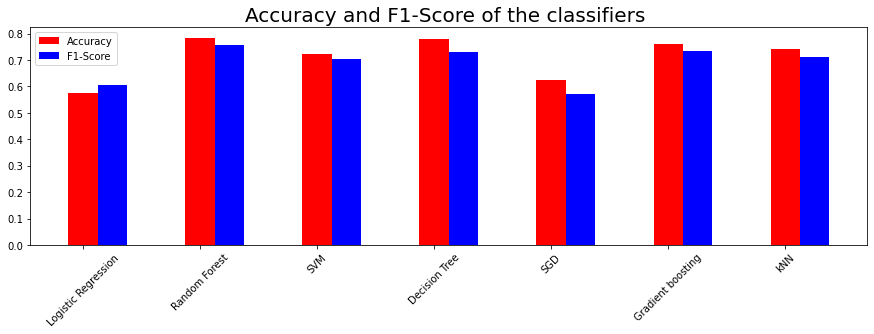

In [18]:
accuracies=[accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6,accuracy7]
f1_scores=[f1_score1,f1_score2,f1_score3,f1_score4,f1_score5,f1_score6,f1_score7]
names = ["Logistic Regression",  "Random Forest", "SVM","Decision Tree","SGD", "Gradient boosting", "kNN"]
barWidth = 0.25
r1 = np.arange(len(accuracies))
r2 = [x + barWidth for x in r1]
    
plt.figure(figsize = (15, 4))
plt.bar(r1, accuracies, color='red', width=barWidth)
plt.bar(r2, f1_scores, color='blue', width=barWidth)
plt.xticks([j for j in range(len(names))], names, rotation = 45);
plt.legend(["Accuracy", "F1-Score"], loc = "upper left")
plt.title("Accuracy and F1-Score of the classifiers ", fontsize = 20)
plt.show()

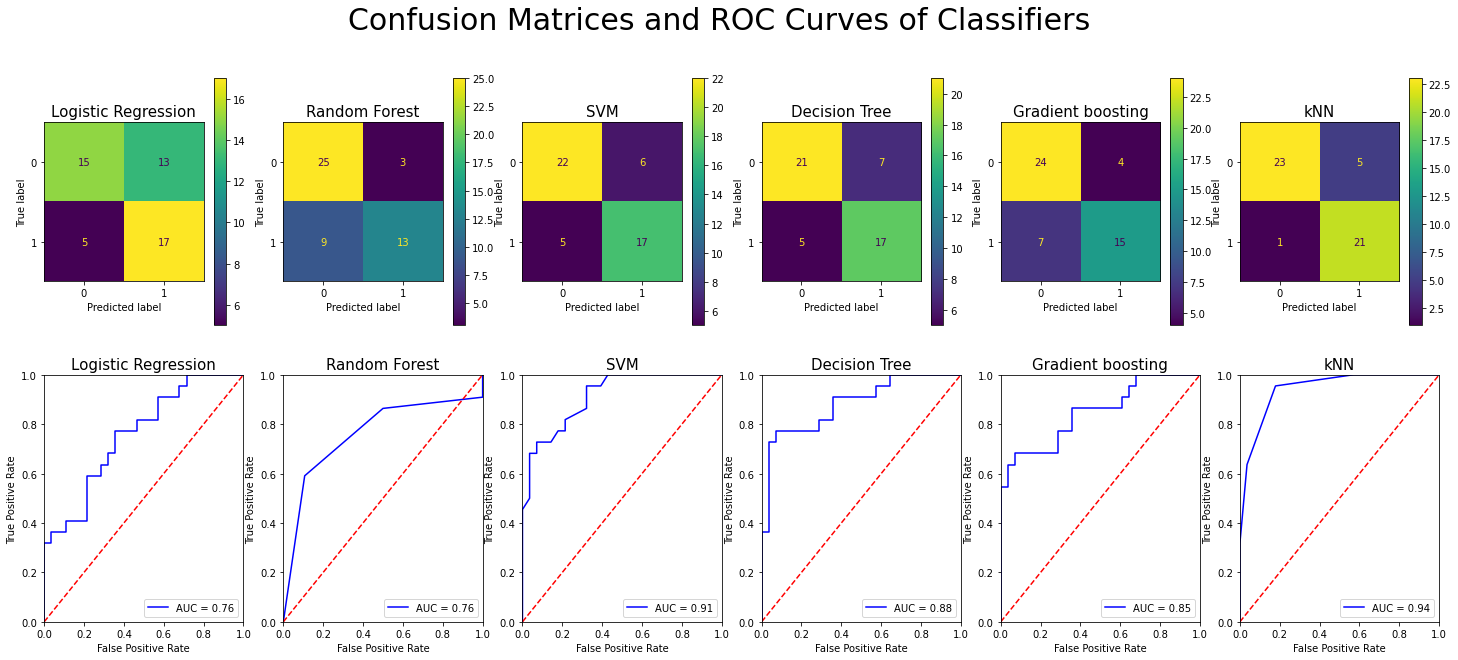

In [19]:
fig, axs = plt.subplots(2, 6, figsize = (25, 10))
models = [logR,Tree,RdForest,SVM,Gradient_boost,Knn]
names = ["Logistic Regression",  "Random Forest", "SVM","Decision Tree", "Gradient boosting", "kNN"]
for i, model in enumerate(models):
    #Confusion Matrix
    plot_confusion_matrix(model, X_test, Y_test, ax = axs[0,i]) 
    axs[0,i].set_title(names[i], fontsize = 15)
    #ROC Curve
    pred_proba= model.predict_proba(X_test)
    FPR, TPR, threshold = roc_curve(Y_test, pred_proba[:, 1])
    roc_auc = auc(FPR, TPR)
    axs[1,i].plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % roc_auc)
    axs[1,i].legend(loc = 'lower right')
    axs[1,i].plot([0, 1], [0, 1],'r--')
    axs[1,i].set_title(names[i], fontsize = 15)
    axs[1,i].set_xlim([0, 1])
    axs[1,i].set_ylim([0, 1])
    axs[1,i].set_ylabel('True Positive Rate')
    axs[1,i].set_xlabel('False Positive Rate')
plt.suptitle("Confusion Matrices and ROC Curves of Classifiers", fontsize = 30)
plt.show()

### Comparaison :
We can see that the classifiers that perform better are : Decision trees , Gradient boost and KNN and SVM with close performance while  the SGD and the Logistic Regression perform less accurate than others. But overall Most of the classifiers performed well with an acceptable accuracy between 70% and 80% and high fscores as well , from the ROC curve we can see that all of the are above the first bisector and auc scores are great with a minimum of 0.76 for logistic regression and random foret and a maximum of 0.94 of KNN.

### Conclusion
In this project we had the opportunity to implement an automatic classificaton of skin lesions based on image processing and classification algorithms of machine learning.
We described the data using geometrical/ morphological descriptors using the binary segmented images and intensity/ texture descriptors using both the original and superpixel images. Using these features we used several machine learning and deep learning classifiers and we tested their performances. The results overall were satisfying and we had some good results especially with the KNN, random forest and gradient boosting classifiers.
We could increase the accuracy of these classifiers by tuning their hyperparameters, unfortunately due to lack of time and the number of classifiers we have to deal with we couldn't do that currently (maybe in a future project).
We can also try to do feature selection because we probably have "too many features" and then test it to see if it increases the perfomance of the models.
We can also try convolutional neural networks to perform classification, but the amount of hyperparameters to tune to outperfom other classifiers , along side with the heavy calculations for each time we test a CNN make the mission quite hard so we decided to not include it in this project.

### References 
- [1] Combining shape and contour features to improve tool wear monitoring in milling processes : https://doi.org/10.1080/00207543.2018.1435919.

- [2] Jason Brownlee :Tour of Evaluation Metrics for Imbalanced Classification https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/.

- [3] https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops.

- [4] Destin Gong : Top 6 Machine Learning Algorithms for Classification https://towardsdatascience.com/top-machine-learning-algorithms-for-classification-2197870ff501.

- [5] https://www.kaggle.com/code/nitinsss/image-classification-with-cnn.

- [6] https://datascientest.com/algorithmes-de-boosting-adaboost-gradient-boosting-xgboost.

- [7] https://pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/.
